### Importing pytorch, numpy, matplotlib

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [12]:
class RBM(nn.Module):
    def __init__(self, num_visible, num_hidden):
        super(RBM, self).__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = nn.Parameter(torch.randn(num_visible, num_hidden))
        self.visible_bias = nn.Parameter(torch.zeros(num_visible))
        self.hidden_bias = nn.Parameter(torch.zeros(num_hidden))

    def forward(self, visible):
        hidden_activations = torch.sigmoid(torch.matmul(visible, self.weights) + self.hidden_bias)
        hidden_sample = torch.bernoulli(hidden_activations)
        reconstructed_visible_activations = torch.sigmoid(torch.matmul(hidden_sample, self.weights.t()) + self.visible_bias)
        return reconstructed_visible_activations, hidden_sample

    def free_energy(self, visible):
        visible_term = torch.matmul(visible, self.visible_bias)
        hidden_term = torch.sum(torch.log(1 + torch.exp(torch.matmul(visible, self.weights) + self.hidden_bias)), dim=1)
        return -visible_term - hidden_term

    def contrastive_divergence(self, input_data, k=1, lr=0.1):
        positive_hidden_activations = torch.sigmoid(torch.matmul(input_data, self.weights) + self.hidden_bias)
        positive_hidden_sample = torch.bernoulli(positive_hidden_activations)
        
        for step in range(k):
            if step == 0:
                hidden_sample = positive_hidden_sample
                negative_visible_activations = torch.sigmoid(torch.matmul(hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_activations)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)
            else:
                negative_visible_activations = torch.sigmoid(torch.matmul(negative_hidden_sample, self.weights.t()) + self.visible_bias)
                negative_visible_sample = torch.bernoulli(negative_visible_activations)
                negative_hidden_activations = torch.sigmoid(torch.matmul(negative_visible_sample, self.weights) + self.hidden_bias)
                negative_hidden_sample = torch.bernoulli(negative_hidden_activations)

        with torch.no_grad():
            positive_associations = torch.matmul(input_data.t(), positive_hidden_activations)
            negative_associations = torch.matmul(negative_visible_sample.t(), negative_hidden_activations)

            self.weights += lr * (positive_associations - negative_associations) / input_data.size(0)
            self.visible_bias += lr * torch.mean(input_data - negative_visible_sample, dim=0)
            self.hidden_bias += lr * torch.mean(positive_hidden_activations - negative_hidden_activations, dim=0)

    def compute_reconstruction_error(self, input_data):
        reconstructed_data, _ = self.forward(input_data)
        error = torch.mean((input_data - reconstructed_data)**2)
        return error.item()

In [14]:
# Example usage:
# Create an RBM with 10 visible units and 5 hidden units
rbm = RBM(num_visible=10, num_hidden=5)

# Generate some dummy data (e.g., binary vectors)
data = torch.tensor(np.random.randint(0, 2, size=(100, 10)), dtype=torch.float32)
data

tensor([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 1., 1., 0., 0., 1., 1.],
        [0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0., 1., 0., 0., 1., 1.],
        [0., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1., 0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
        [0., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 0., 1., 1., 0., 0., 0., 1., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],


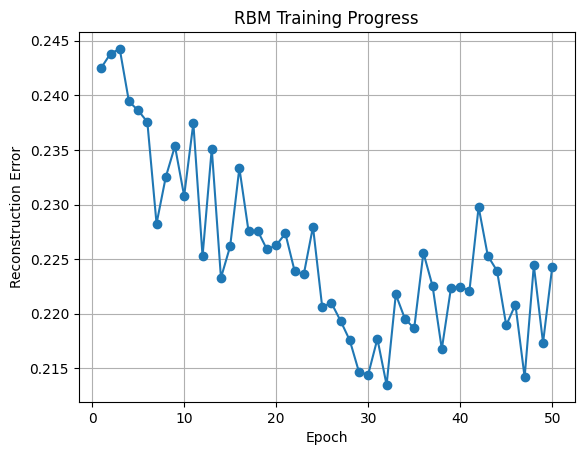

In [15]:
# Train the RBM on the dummy data using contrastive divergence
reconstruction_errors = []
for epoch in range(50):
    rbm.contrastive_divergence(data)
    error = rbm.compute_reconstruction_error(data)
    reconstruction_errors.append(error)

# Plot the reconstruction error over epochs
plt.plot(range(1, 51), reconstruction_errors, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.title('RBM Training Progress')
plt.grid(True)
plt.show()